In [ ]:
#Problem 2: Sentiment Analysis using Transformer-based Transfer Learning
##SYSEN6888 DL499 Nov 3, 2023

In [ ]:
#package dependency installs
!pip install datasets
!pip install torch
!pip install -U transformers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.5 MB/s eta 0:00:00


In [ ]:
#IMDB Dataset import and training split
from datasets import load_dataset

# Load the IMDB dataset
raw_datasets = load_dataset("imdb")

# Shuffle and split the data into training and validation sets
train_dataset = raw_datasets['train']
train_dataset = train_dataset.shuffle(seed=42)
tokenized_valid = train_dataset.select(range(1000))
tokenized_train = train_dataset.select(range(1000, len(train_dataset)))

# Print some information about the datasets
print(f"Number of training samples: {len(tokenized_train)}")
print(f"Number of validation samples: {len(tokenized_valid)}")


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Number of training samples: 24000
Number of validation samples: 1000


In [ ]:
#data tokenization of the reviews for training and validation, uses autotokenizer from transformers

from transformers import AutoTokenizer

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

def tokenize_and_format(examples):
    # Tokenize the texts
    tokenized_batch = tokenizer(examples["text"], padding="max_length", truncation=True)
    # Map labels to integers
    tokenized_batch["labels"] = [int(label) for label in examples["label"]]
    return tokenized_batch

# Apply the tokenization and formatting function to the datasets
tokenized_train = tokenized_train.map(tokenize_and_format, batched=True, remove_columns=["text", "label"])
tokenized_valid = tokenized_valid.map(tokenize_and_format, batched=True, remove_columns=["text", "label"])

# Set format for pytorch tensors
tokenized_train.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_valid.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])


# Display some information about the tokenized datasets
print(f"Number of tokenized training samples: {len(tokenized_train)}")
print(f"Number of tokenized validation samples: {len(tokenized_valid)}")

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Number of tokenized training samples: 24000
Number of tokenized validation samples: 1000


In [ ]:
#deployment of ALBERT model on IMDB

from transformers import AlbertForSequenceClassification

# Initialize the model
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)

# Print model architecture
print(model)


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model_path = "/content/drive/MyDrive/Colab Notebooks/Trained Models/ALBERT-finetuned-IMDB"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#training configuration for ALBERT model
from transformers import Trainer, TrainingArguments, TrainerCallback, get_linear_schedule_with_warmup
import os
import torch
from tqdm import tqdm
from datasets import load_metric
import matplotlib.pyplot as plt

num_train_epochs = 20
per_device_train_batch_size = 40

# Calculate the number of training steps
num_train_steps = (len(tokenized_train) // per_device_train_batch_size) * num_train_epochs

# Define warmup_steps as 10% of training steps
warmup_steps = int(num_train_steps * 0.1)

# Configure training parameters
training_args = TrainingArguments (
    output_dir=('/content/drive/MyDrive/Colab Notebooks/Training Files Temp'),
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=40,
    learning_rate= 1e-5,
    weight_decay=0.01,
    logging_dir='./logs',  # directory for storing logs
    evaluation_strategy="epoch",  # evaluate at the end of each epoch
    save_strategy="epoch",  # save the model after each epoch
    load_best_model_at_end=True,       # load the best model at the end of training
    metric_for_best_model="accuracy",  # use accuracy as the metric for early stopping
    warmup_steps=warmup_steps  # number of warmup steps for learning rate scheduler
)


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    compute_metrics=compute_metrics,
    #callbacks=[ComputeTrainMetricsCallback]
)

In [17]:
# Train the model
trainer.train()
#save trained model
model_path = "./content/drive/MyDrive/Colab Notebooks/Trained Models/ALBERT-finetuned-IMDB"
trainer.save_model(model_path)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.407400,0.218041,0.921000,0.916754,0.943601,0.891393
2,0.192400,0.189955,0.934000,0.931393,0.945148,0.918033
3,0.159500,0.232698,0.923000,0.917823,0.957684,0.881148
4,0.118400,0.290040,0.926000,0.920940,0.962054,0.883197
5,0.054400,0.399601,0.934000,0.931106,0.948936,0.913934
6,0.035000,0.387206,0.936000,0.934292,0.936214,0.932377
7,0.023900,0.469694,0.923000,0.918862,0.945770,0.893443
8,0.020200,0.498087,0.937000,0.934850,0.943633,0.926230
9,0.010400,0.532160,0.932000,0.929897,0.935685,0.924180
10,0.009000,0.598614,0.933000,0.930281,0.945032,0.915984


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.407400,0.218041,0.921000,0.916754,0.943601,0.891393
2,0.192400,0.189955,0.934000,0.931393,0.945148,0.918033
3,0.159500,0.232698,0.923000,0.917823,0.957684,0.881148
4,0.118400,0.290040,0.926000,0.920940,0.962054,0.883197
5,0.054400,0.399601,0.934000,0.931106,0.948936,0.913934
6,0.035000,0.387206,0.936000,0.934292,0.936214,0.932377
7,0.023900,0.469694,0.923000,0.918862,0.945770,0.893443
8,0.020200,0.498087,0.937000,0.934850,0.943633,0.926230
9,0.010400,0.532160,0.932000,0.929897,0.935685,0.924180
10,0.009000,0.598614,0.933000,0.930281,0.945032,0.915984


In [18]:
from transformers import pipeline

# Construct an absolute path to the model directory
model_path = os.path.join(os.getcwd(), "content/drive/MyDrive/Colab Notebooks/Trained Models/ALBERT-finetuned-IMDB")

# Make sure the model path exists
if not os.path.isdir(model_path):
    raise ValueError(f"The specified model path does not exist: {model_path}")

# Extract accuracy and loss from history
training_loss = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]
validation_loss = [entry['eval_loss'] for entry in trainer.state.log_history if 'eval_loss' in entry]

validation_accuracy = [entry['eval_accuracy'] for entry in trainer.state.log_history if 'eval_accuracy' in entry]
training_accuracy = [entry['accuracy'] for entry in trainer.state.log_history if 'accuracy' in entry]  # Added line

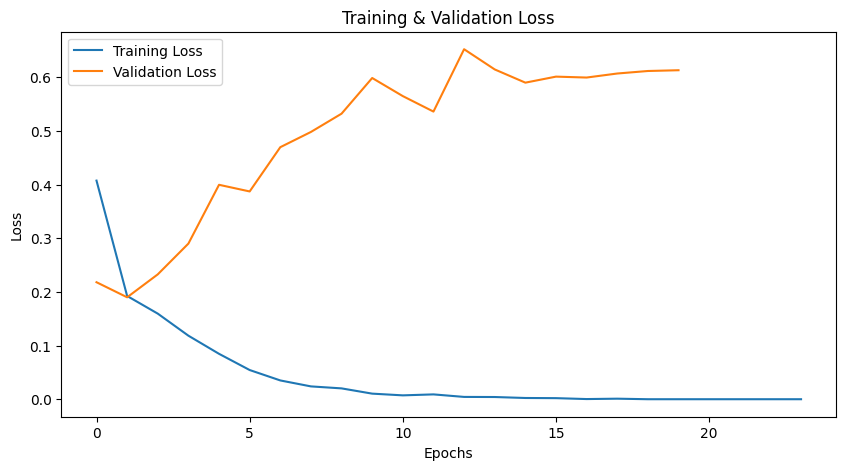

In [19]:
# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

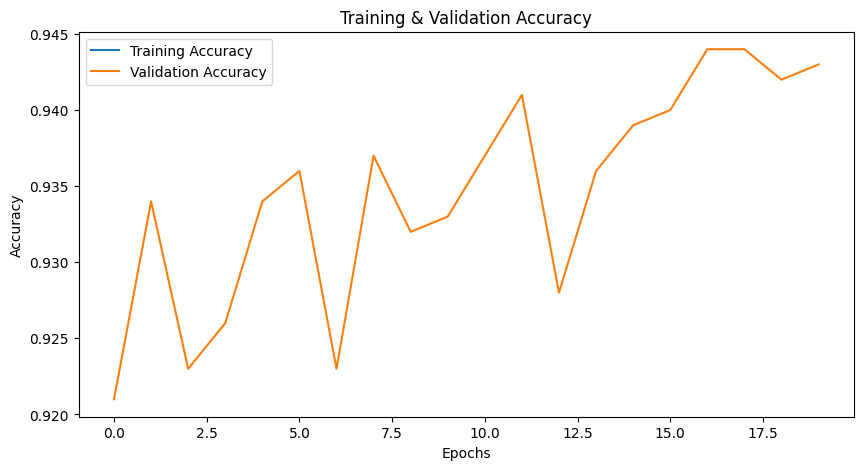

In [20]:
# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [21]:
# Load the trained model using the absolute path
classifier = pipeline("sentiment-analysis", model=model_path, tokenizer=tokenizer)

# Predict the sentiment of the sentence
prediction = classifier("This movie was really amazing!")

# Output the prediction
print(prediction)

[{'label': 'LABEL_1', 'score': 0.9997813105583191}]
